# Spectroscopic science with the Roman GPS

The purpose of this notebook is to explore the science cases for spectroscopy recommended to the Roman Galactic Plane Survey. 

In [37]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
import config_utils
import survey_footprints
import regions
import healpy as hp
from mw_plot import MWSkyMap, MWSkyMapBokeh
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord, ICRS
from astropy.table import Table, Column
from astropy.io import ascii
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from os import path
%matplotlib inline


# Configure path to local repository
root_dir = '/Users/rstreet/software/rgps'

# Load essential configuration
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

# HEALpixel grid resolution
NSIDE = sim_config['NSIDE']
PIXAREA = hp.nside2pixarea(NSIDE, degrees=True)

Descriptions of all of the science cases are captured in the config/rgps_science_cases.json document, including the definitions of what regions of sky the authors would like to observe.  These have been converted into HEALpixel maps for convenience, so we load those region maps as well. 

In [2]:
science_cases = config_utils.read_config(path.join(root_dir, 'config', 'rgps_science_cases.json'))

In [3]:
science_regions = regions.load_regions_from_file(sim_config,
                                                         path.join(root_dir, 'region_data', 'rgps_science_regions_spectroscopy.json'))

Using the science cases, we can identify the subset of cases that request spectroscopic observations.

In [4]:
spectro_cases = {}
for author, info in science_cases.items():
    if 'P127' in info.keys() or 'G150' in info.keys():
        spectro_cases[author] = info

print('Number of spectroscopic science cases = ' + str(len(spectro_cases)))
print('\n')
for author, params in spectro_cases.items():
    print(author + ': ' + params['comment'])
    for optic in ['P127', 'G150']: 
        if optic in params.keys():
            for r in params[optic]:
                if 'l' in r.keys(): 
                    footprint = 'l: ' + repr(r['l']) + ', b:' + repr(r['b'])
                elif 'pointing' in r.keys():
                    footprint = 'pointing: ' + repr(r['pointing'])
                elif 'survey_footprint' in r.keys(): 
                    footprint = 'survey footprint: ' + r['survey_footprint'] 
                elif 'catalog' in r.keys():
                    footprint = 'catalog: ' + r['catalog']
                    
                print('  ' + optic + ' region=' + r['name'] + ' visit intervals=' + repr(r['visit_interval']) + ' footprint=' + footprint)

Number of spectroscopic science cases = 8


Anderson: Ionized Hydrogen in ISM.  F184 filter there could be other bright lines, so it may be difficult to isolate emission from Pa-alpha without G150 for at least a selected sub-region
  G150 region=HII1 visit intervals=[None] footprint=l: [-90.0, 90.0], b:[-2.5, 2.5]
Lim1: Young Stellar Object spectroscopy
  G150 region=YSO_spec1 visit intervals=[None] footprint=l: [55.0, 65.0], b:[-1.0, 1.0]
Rich2: Stellar populations; time domain survey of nuclear region
  P127 region=Rich_TDA1 visit intervals=[0.25] footprint=l: [359.544, 360.0], b:[-0.3, 0.3]
  P127 region=Rich_TDA2 visit intervals=[0.25] footprint=l: [0.0, 0.344], b:[-0.3, 0.3]
  G150 region=Rich_TDA1 visit intervals=[0.25] footprint=l: [359.544, 360.0], b:[-0.3, 0.3]
  G150 region=Rich_TDA2 visit intervals=[0.25] footprint=l: [0.0, 0.344], b:[-0.3, 0.3]
Lim3_grism_targets: W51, M17 and/or M16, in priority order, from Wanggi Lim
  G150 region=RGPS_M17 visit intervals=[None] footprint

Build a dictionary of the regions corresponding to these science cases.

In [5]:
spectro_regions = {} 
for author, info in spectro_cases.items(): 
    # Not all of the cases are sufficiently well defined as to enable regions to be built
    if author in science_regions.keys():
        spectro_regions[author] = science_regions[author]
    else: 
        print('Warning: science case for ' + author + ' is incompletely specified')
print('Regions defined for ' + str(len(spectro_regions)) + ' spectroscopic regions')

Regions defined for 8 spectroscopic regions


## Regions requested for spectroscopic observations 

Here we combine all of the regions requested for all of the science cases to create a map of the regions of interest for both the prism and grism elements. 

In accordance with the priorities of the committee, fields should be distributed across the Galactic Plane covering a wide range of stellar densities in both north and south.  The fields for Hillenbrand's proposals aimed to do exactly this, so we give those fields additional priority. 

In [6]:
r = spectro_regions['Hillenbrand']['G150'][0]
r.pixel_priority[r.pixels] += 3.0
spectro_regions['Hillenbrand']['G150'][0] = r

Maximum HEALpixel value = 2.0, total number of HEALpixels = 4
Maximum HEALpixel value = 4.0, total number of HEALpixels = 2461


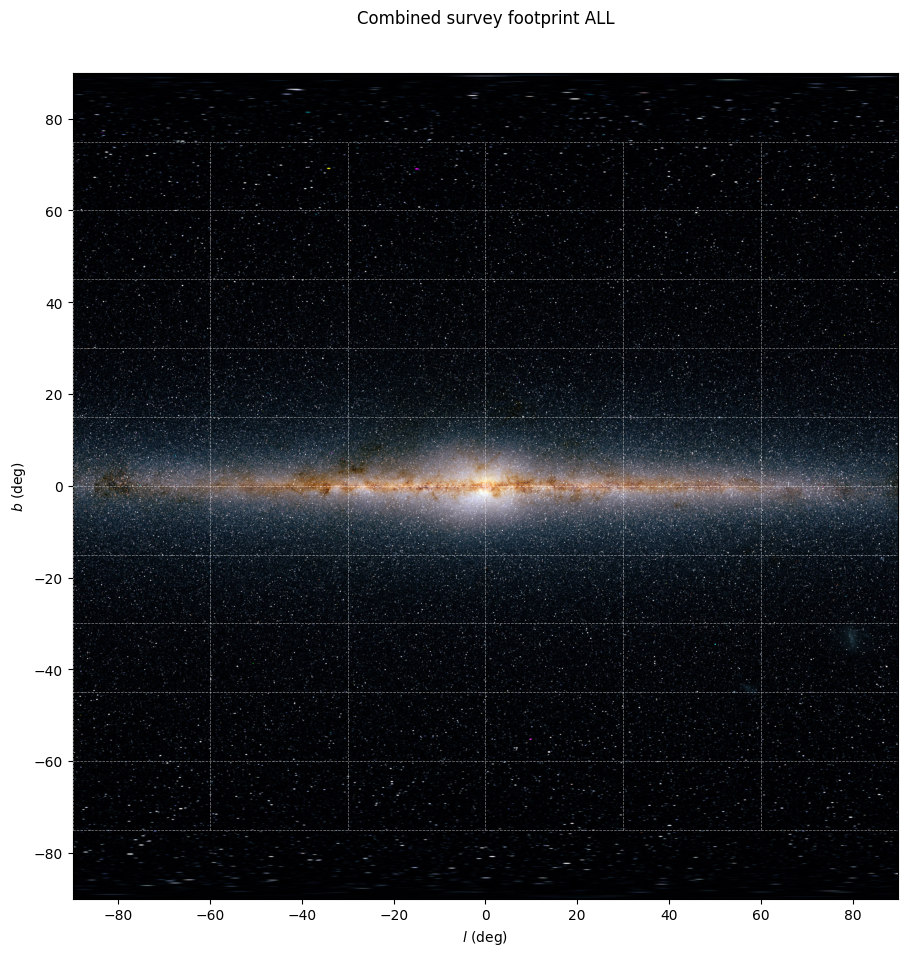

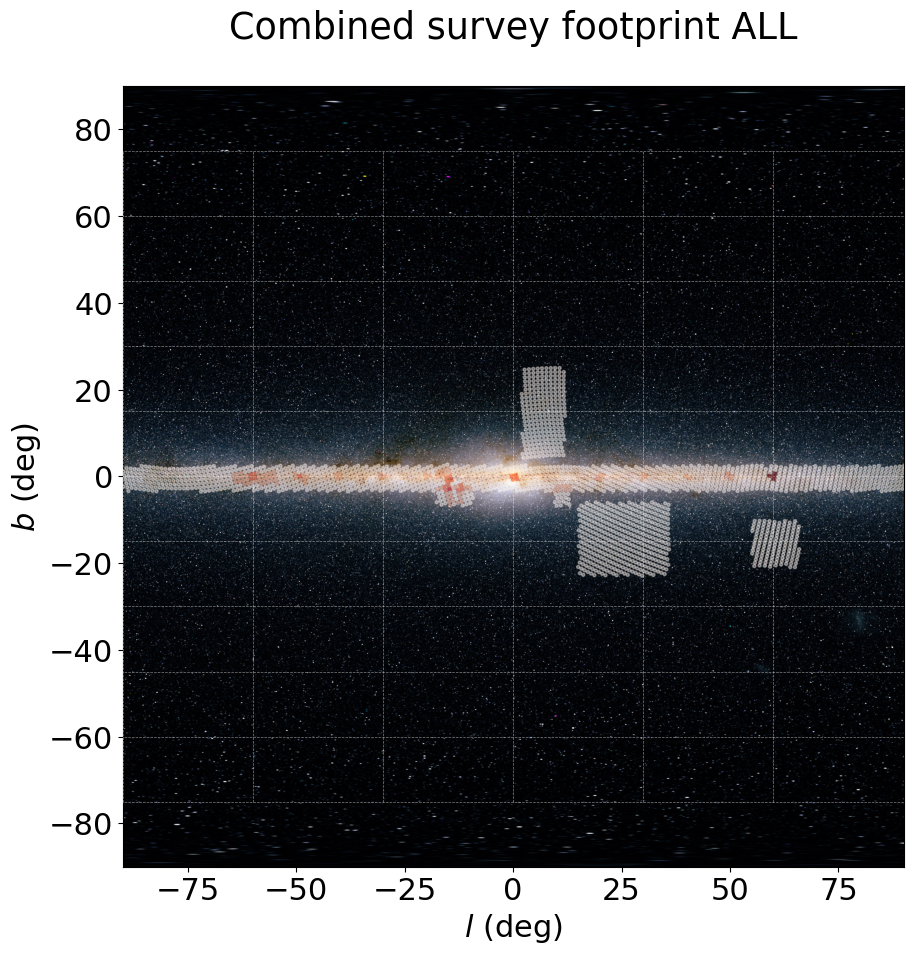

In [7]:
# Map the regions of interest separately for the prism and grism
combined_regions = {}

for optic in ['P127', 'G150']: 
    
    # Compile a list of regions for this optic over all science cases 
    region_list = []
    region_names = []
    
    for author, params in spectro_regions.items():
        if optic in params.keys():

            # Do not duplicate a region if an author has requested it for multiple filters
            for r in params[optic]:
                if r.name not in region_names:
                    region_list.append(r)
                    region_names.append(r.name)

    if len(region_list) > 0:
        r_merge = regions.combine_regions(region_list)
        
        print('Maximum HEALpixel value = ' + str(r_merge.region_map.max())+', total number of HEALpixels = ' + str(len(r_merge.pixels)))

        r_merge.optic = 'ALL'
        r_merge.label = 'Combined survey footprint'
    
        mw1 = MWSkyMap(grayscale=False, grid='galactic', background='infrared', figsize=(16, 10), 
                      center=(0.0*u.deg, 0.0*u.deg), radius=(90.0*u.deg, 90.0*u.deg))
        mw1.title = r_merge.label + ' ' + r_merge.optic
        s = r_merge.pixels_to_skycoords()
        mw1.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c=r_merge.pixel_priority[r_merge.pixels]*10, cmap='Reds', s=5, alpha=0.4)
        plt.rcParams.update({'font.size': 22})
    
        plt.tight_layout()
        plt.savefig(path.join(root_dir, 'spectroscopy', 'combined_regions_map_' + optic + '.png'))

        combined_regions[optic] = r_merge

    else:
        combined_regions[optic] = None

## Priority regions for spectra

Only a few HEALpixels were selected for observations with the prism and they are non-contiguous. 

For the grism however, a few regions stand out as being highly recommended targets.  So in this section we identify where those are.

N overlap science cases=2 N HEALpixels=122 area=102.39sq.deg.


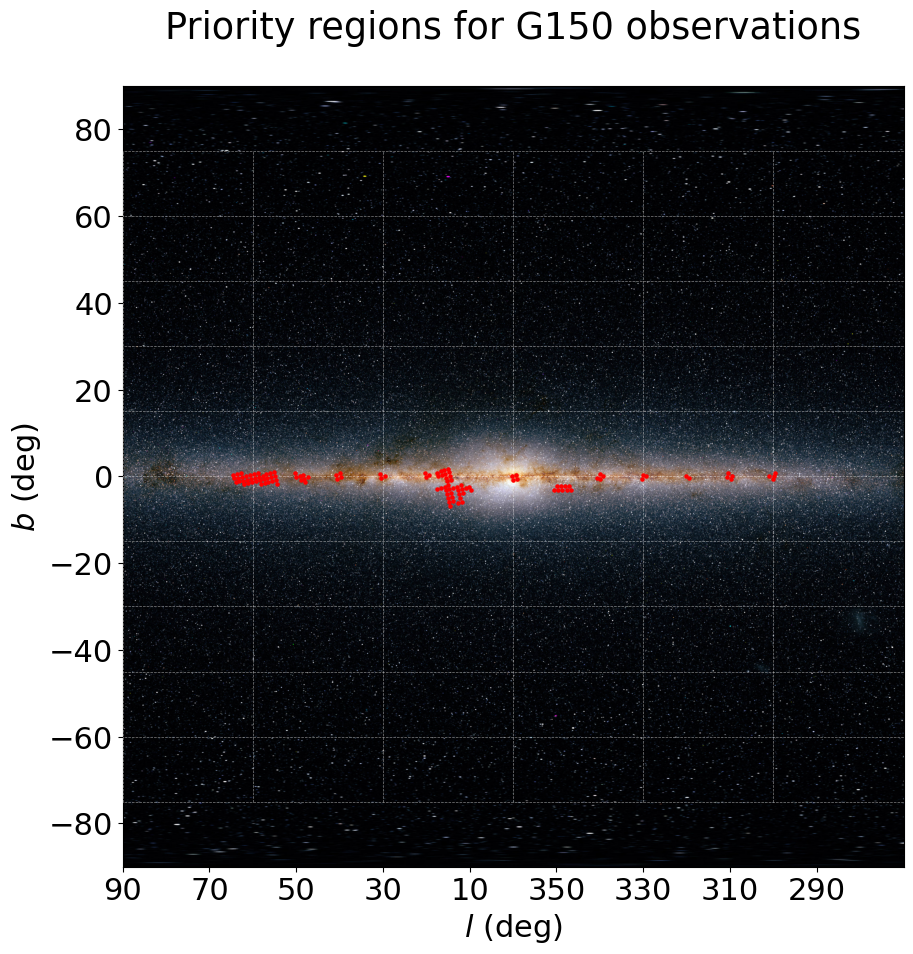

In [35]:
threshold = 2.0 # Minimum number of science cases requesting a HEALpixel in any filter

r_merge = combined_regions['G150']

pixels = np.where(r_merge.pixel_priority >= threshold)[0]

candidate_regions = {'pixel_set': pixels}

area = len(pixels) * PIXAREA
print('N overlap science cases=' + str(int(threshold)) 
      + ' N HEALpixels=' + str(len(pixels)) + ' area=' + str(round(area,2)) + 'sq.deg.')

# Plot these regions 
mw1 = MWSkyMap(grayscale=False, grid='galactic', background='infrared', figsize=(16, 10), 
                      center=(0.0*u.deg, 0.0*u.deg), radius=(90.0*u.deg, 90.0*u.deg))
mw1.title = 'Priority regions for G150 observations'
proj = HEALPix(nside=64, order='ring', frame='icrs')

s = proj.healpix_to_skycoord(pixels)
mw1.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c='r', s=5, alpha=1.0)
plt.rcParams.update({'font.size': 22})

(xmin, xmax, ymin, ymax) = plt.axis()
xticks = np.arange(xmin, xmax, 20.0)
xticklabels = []
for x in xticks:
    if x == 0.0:
        xticklabels.append(str(0.0))
    else:
        xp = x*-1.0
        if xp < 0.0:
            xp = 360.0 + xp
        xticklabels.append(str(round(xp)))
#xticklabels = [str(round(x*-1.0,0)) for x in xticks]

plt.xticks(xticks, xticklabels)

plt.tight_layout()
plt.savefig(path.join(root_dir, 'spectroscopy', 'priority_regions_G150.png'))


We identify the boundaries of these regions based on HEALpixel clustering.

In [25]:
def get_lrange(llist):

    idx1 = np.where(llist > 180.0)[0] 
    idx2 = np.where(llist <= 180.0)[0] 

    l0 = llist[idx1].min() 
    l1 = llist[idx2].max() 

    return l0, l1

In [26]:
def cluster_pixels(params):
    
    # Convert the HEALpixels to a set of Skycoords in the galactic frame
    proj = HEALPix(nside=64, order='ring', frame='icrs')
    pixels = params['pixel_set']
    coords = proj.healpix_to_skycoord(pixels)
    coords = coords.transform_to('galactic')

    clusters = {}
    nc = -1
    max_sep = 2.5 * u.deg
    while len(coords) > 0:
        s = coords[0]
        
        sep = s.separation(coords)

        jdx = np.where(sep <= max_sep)[0]
        kdx = np.where(sep > max_sep)[0]
        
        l = coords[jdx].l.deg
        lmin = l.min() 
        lmax = l.max()
        print('RANGE: ',l, coords[jdx].b.deg)
        
        # Handle case if the region straddles the l-coordinate rollover
        if lmin > 0.0 and lmin < 180.0 and lmax > 180.0: 
            l0,l1 = get_lrange(l)
        else:
            l0 = l.min()
            l1 = l.max() 
        b0 = coords[jdx].b.deg.min()
        b1 = coords[jdx].b.deg.max()
        print('CORNERS: ', lmin, lmax, l0, l1, b0, b1)
        
        # Calculate the centroid as the mid-point of the diagonal between 
        # the opposing corners of a box encompasing the all HEALpixels in the region
        corner1 = SkyCoord(l0, b0, frame='galactic', unit=(u.deg, u.deg))
        corner2 = SkyCoord(l1, b1, frame='galactic', unit=(u.deg, u.deg))
        pa = corner1.position_angle(corner2)
        sep = corner1.separation(corner2)
        center = corner1.directional_offset_by(pa, sep/2)  
        
        cluster = { 
            'l_center': center.l.deg,
            'b_center': center.b.deg,
            'l0': l0,
            'l1': l1,
            'b0': b0,
            'b1': b1,
            'pixels': pixels[jdx]
        }
        nc += 1 
        
        clusters[nc] = cluster

        # Remove identified pixels from the coords list 
        coords = coords[kdx]
        pixels = pixels[kdx]
        
    params['clusters'] = clusters

    return params

In [27]:
region_set = {}
params = cluster_pixels(candidate_regions)

# Filter out clusters that are unfeasibly large
for key, value in params.items():
    if key == 'clusters':
        subset = {}
        for cid,cluster in params['clusters'].items():
            #dl = abs(cluster['l0'] - cluster['l1'])
            #if len(cluster['pixels']) < 20.0 and dl < 20.0:
            print(' -> ', cid, cluster)
            subset[cid] = cluster
        params['clusters'] = subset
    else:
        print(key, value)
    
candidate_regions = params

RANGE:  [60.65396415 59.76726452 60.40842587 59.52182146] [ 0.33509388  0.5659603  -0.54762817 -0.31670871]
CORNERS:  59.52182146138827 60.653964146222904 59.52182146138827 60.653964146222904 -0.5476281672377089 0.5659602956776258
RANGE:  [49.21379692] [0.060364]
CORNERS:  49.21379691548253 49.21379691548253 49.21379691548253 49.21379691548253 0.06036400145536927 0.06036400145536927
RANGE:  [15.37471138 14.50771073 15.14495181 15.77450932 14.27813368 14.90922288] [-0.29716095  0.003864   -1.18571029 -2.37951121 -0.88448416 -2.07246945]
CORNERS:  14.278133678361506 15.774509318530411 14.278133678361506 15.774509318530411 -2.3795112130168987 0.0038639976904473513
RANGE:  [15.53272904 14.66717742] [-3.26469429 -2.95732739]
CORNERS:  14.667177416853587 15.532729035881472 14.667177416853587 15.532729035881472 -3.264694289925223 -2.957327385389062
RANGE:  [12.06106565 12.68192837 11.81118938] [-2.07003045 -3.24185525 -2.9519149 ]
CORNERS:  11.811189377332962 12.681928373999089 11.81118937733

In [28]:
# Pixel clusters are separated by assuming they have to be a maximum angular separation apart
max_sep = 2.5*u.deg
optic_col = []
data = np.array([])
ids = []
centroids = np.array([])
for cid,cluster in candidate_regions['clusters'].items():
    s = SkyCoord(cluster['l_center'], cluster['b_center'], frame='galactic', unit=(u.deg, u.deg))

    # Check whether we already have a region at this location 
    if len(centroids) > 0: 
        cluster_centroids = SkyCoord(centroids[:,0], centroids[:,1], frame='galactic', unit=(u.deg, u.deg))
        sep = s.separation(cluster_centroids) 
        
        # If not, then add a new cluster
        if (sep >= max_sep).all():                
            ids.append(len(ids))
            data = np.vstack((data,[
                cluster['l_center'], cluster['b_center'], 
                cluster['l0'], cluster['l1'], cluster['b0'], cluster['b1']
            ]))

            optic_col.append(optic)

            centroids = np.vstack((centroids, [cluster['l_center'], cluster['b_center']]))
            
        # If the cluster is already known, compare the boundaries and extend if need be to  
        # form the cluster superset of pixels.  Also add the optic to the list of optics requesting 
        # this cluster
        else:
            #print('Existing clusters: ', cluster_centroids)
            #print('Candiddate cluster ',s)
            
            #print('Separations: ',sep, max_sep)
            
            cid = np.where(sep <= max_sep)[0][0]
            if len(data.shape) == 1: 
                cmatch = data
            else:
                cmatch = data[cid,:]
            superset = False 
            if superset:
                cmatch[2] = min(cmatch[2], cluster['l0']) 
                cmatch[3] = max(cmatch[3], cluster['l1']) 
                cmatch[4] = min(cmatch[4], cluster['b0']) 
                cmatch[5] = max(cmatch[5], cluster['b1'])
                cmatch[0] = np.median([cmatch[2],cmatch[3]])
                cmatch[1] = np.median([cmatch[4],cmatch[5]])
                if len(data.shape) == 1:
                    data = cmatch
                else:
                    data[cid,:] = cmatch
            if optic not in optic_col[cid]:
                optic_col[cid] = optic_col[cid] + ', ' + optic
            
    # If we have no clusters yet, simply add a new one 
    else:
        ids.append(len(ids))
        data = np.array([
            cluster['l_center'], cluster['b_center'], 
            cluster['l0'], cluster['l1'], cluster['b0'], cluster['b1']
        ])
        optic_col.append(optic)

        centroids = np.array([[cluster['l_center'], cluster['b_center']]])
                
data = np.array(data)

# Allow for testing with a single filter
if len(data.shape) == 1:
    Spectro_regions = Table([
        Column(name='ID', data=ids),
        Column(name='l_center', data=[data[0]]),
        Column(name='b_center', data=[data[1]]),
        Column(name='l0', data=[data[2]]),
        Column(name='l1', data=[data[3]]),
        Column(name='b0', data=[data[4]]),
        Column(name='b1', data=[data[5]])
    ])

else:
    Spectro_regions = Table([
        Column(name='ID', data=ids),
        Column(name='l_center', data=data[:,0]),
        Column(name='b_center', data=data[:,1]),
        Column(name='l0', data=data[:,2]),
        Column(name='l1', data=data[:,3]),
        Column(name='b0', data=data[:,4]),
        Column(name='b1', data=data[:,5])
    ])

Spectro_regions.pprint_all()

 ID      l_center            b_center               l0                 l1                  b0                   b1         
--- ------------------ -------------------- ------------------ ------------------ ------------------- ---------------------
  0  60.08789192370698 0.009166511590753738  59.52182146138827 60.653964146222904 -0.5476281672377089    0.5659602956776258
  1  49.21379691548253  0.06036400145536927  49.21379691548253  49.21379691548253 0.06036400145536927   0.06036400145536927
  2 15.026644220976209  -1.1879248598184284 14.278133678361506 15.774509318530411 -2.3795112130168987 0.0038639976904473513
  3  12.24676541314579   -2.656019419930341 11.811189377332962 12.681928373999089 -3.2418552542580437   -2.0700304495424504
  4  359.7122900035529  -0.2565020874184945 359.12775676696447 0.2967754209918428 -0.7800015493729588    0.2670240688620124
  5  300.3071958873561 0.012104647151108178 299.67446349414763  300.9399317343068 -0.7280405011747532    0.7522483192778171


## Interactively Revised Fields

These pixel clustering techniques have been used to identify "nominal" pointings, with the expectation of review by the committee to adjust their boundaries to include regions of additional special scientific interest if possible.  

With this in mind the expanded set of spectroscopic fields (candidate_grism_fields_table_full.txt, created using a low selection threshold) was compared with the spectroscopic fields selected with a higher threshold (candidate_grism_fields_table_limited.txt), which identified smaller individual regions in certain cases.  Lastly, this was compared with the set of time domain fields (selected_tda_candidate_tda_fields.txt) to come up with a combined list of ~13 pointings for which to acquire spectroscopy.  This list is stored in candidate_grism_fields_table_revised.txt.  

In [39]:
spectro_fields = ascii.read(path.join(root_dir, 'spectroscopy', 'candidate_grism_fields_table_revised.txt'))
spectro_fields

<Table length=14>
  ID       l_center      ...          b0                   b1         
int64      float64       ...       float64              float64       
----- ------------------ ... ------------------- ---------------------
    0  60.08789192370698 ... -0.5476281672377089    0.5659602956776258
    4 49.216854518454696 ...  -0.831190610644845     0.642225641408821
    5  40.29500990270717 ... -0.5537334429785405    0.6874859710921811
    2 28.050816657433884 ... -0.4766073328462903   -0.1266892528610955
    3  25.37605755001467 ...  1.4651381451102967    2.7070063210966073
    2 15.026644220976209 ... -2.3795112130168987 0.0038639976904473513
    3  12.24676541314579 ... -3.2418552542580437   -2.0700304495424504
   12  359.7122900035529 ... -0.7800015493729588    0.2670240688620124
   13  349.1102982524819 ...  -3.247706805682061   -2.2894736968568274
   14 339.93578040642876 ... -0.7291064534002245   0.42869749383269334
   15 329.78177680878014 ...  -0.683001048277715    0.3876589429409526
   16  319.7767952856863 ... -0.3512325618282731   0.04554475489356981
   17  310.1795585396104 ... -0.6339689144571816    0.7313757645386222
   18  300.3071958873561 ... -0.7280405011747532    0.7522483192778171

## Stellar density of target fields

At the time of planning the RGPS, it remains unclear how well Roman will be able to guide in dense stellar fields when the spectroscopic elements are in use.  So one goal of the spectrscopic program may be to acquire observations in fields of a range of stellar densities with the goal of demonstrating the spacecraft's performance for future reference.  

So it is useful to check here what range of stellar densities these fields cover, based on TriLegal model data.  

WARNING: This does not yet include an extinction model!

In [40]:
trilegal_model = config_utils.read_config(path.join(root_dir, 'trilegal_model_data', 'trilegal_nir_stellar_density.json'))
trilegal_map = np.array(trilegal_model['healpix_map_G150'])

In [41]:
def create_region_from_boundaries(params):

    # First check for circular regions:
    lspan = params['l1'] - params['l0']
    bspan = params['b1'] - params['b0']
    if lspan == 0.0 and bspan == 0.0: 
        coords = [{"pointing": [params['l0'], params['b0'], 0.3]}]

    # Otherwise handle box regions, bearing in mind they may extend over the l=360/0 boundary
    else:
        if params['l1'] <= 180.0 and params['l1'] > params['l0']:
            coords = [{
                "l": [
                    params['l0'],
                    params['l1']
                ],
                "b": [
                    params['b0'],
                    params['b1']
                ],
            }]
        else:
            coords = [{
                "l": [
                    params['l0'],
                    359.9
                ],
                "b": [
                    params['b0'],
                    params['b1']
                ],
            },
                      {
                "l": [
                    0.0,
                    params['l1']
                ],
                "b": [
                    params['b0'],
                    params['b1']
                ],
            }]

    rconfiglist = []
    for c in coords:
        conf = {
            "nvisits": 1,
            "duration": 730.0,
            "visit_interval": [None],
            "name": str(params['ID'])
        }
        for key, entry in c.items():
            conf[key] = entry
        rconfiglist.append(conf)
        
    config = {
        str(params['ID']): {
            "G150": rconfiglist,
            "comment": "None",
            "ready_for_use": "True"
        }
    }
    
    r = regions.build_region_maps(sim_config, config)

    # If the region has multiple entries, merge them into a single region for convenience
    if len(r[str(params['ID'])]['G150']) > 1:
        r_merge = regions.combine_regions(r[str(params['ID'])]['G150'])
        r[str(params['ID'])]['G150'] = [r_merge]
    
    return r

In [43]:
region_stellar_densities = []
for row in spectro_fields:
    # Convert each candidate region to a CelestialRegion object to take advantage of its precalculated HEALpixel map
    r = create_region_from_boundaries(row)

    # Calculate the median stellar density for each region, based on the Trilegal model 
    r_merge = r[str(row['ID'])]['G150'][0]
    region_stellar_densities.append(np.log10(np.median(trilegal_map[r_merge.pixels])))

# Add a column to the TD_regions table with the stellar density data 
spectro_fields['log10_stellar_density'] = region_stellar_densities

spectro_fields.pprint_all()

 ID      l_center            b_center               l0                 l1                  b0                   b1          log10_stellar_density
--- ------------------ -------------------- ------------------ ------------------ ------------------- --------------------- ---------------------
  0  60.08789192370698 0.009166511590753738  59.52182146138827 60.653964146222904 -0.5476281672377089    0.5659602956776258    7.1598280255582125
  4 49.216854518454696 -0.09449951743088682  48.12897162013072  50.30469127642108  -0.831190610644845     0.642225641408821     7.357847857871828
  5  40.29500990270717  0.06687916670962922  39.76120073688036  40.82883256737757 -0.5537334429785405    0.6874859710921811     7.497694976859264
  2 28.050816657433884  -0.3016566470630278 27.624388519213877  28.47723108449249 -0.4766073328462903   -0.1266892528610955     7.666885593735789
  3  25.37605755001467    2.086364964378666 24.416209200921237  26.33666409830028  1.4651381451102967    2.7070063210966073 

In [44]:
# Output to file 
spectro_fields.write(path.join(root_dir, 'spectroscopy', 'candidate_grism_fields_table_revised.txt'), format='ascii', overwrite=True)

## Science cases included in selected fields

Its important to review the science cases and selected fields to identify science that is - and is not - covered by the selected fields. 

In [18]:
spectro_survey = {} 

for row in Spectro_regions:

    # Need to catch region boxes that extend over l=360/0deg and split them into two regions if they 
    # straddle the boundary
    if row['l0'] > 180.0 and row['l0'] > row['l1']:
        params = {
            "G150": [
                { # Nominal filter used to fit required structure
                "l": [row['l0'], 359.9],
                "b": [row['b0'], row['b1']],
                "nvisits": 1,
                "duration": 730.0,
                "visit_interval": [None],
                "name": str(row['ID'])
                },
                { 
                "l": [0.0, row['l1']],
                "b": [row['b0'], row['b1']],
                "nvisits": 1,
                "duration": 730.0,
                "visit_interval": [None],
                "name": str(row['ID'])
                },
            ],
            "comment": "None",
            "ready_for_use": "True"
        }

    elif (row['l0'] == row['l1'] and row['b0'] == row['b1']):
        params = {
            "G150": [{ # Nominal filter used to fit required structure
                "pointing": [row['l0'], row['b1'], 0.3],
                "nvisits": 1,
                "duration": 730.0,
                "visit_interval": [None],
                "name": str(row['ID'])
                }],
            "comment": "None",
            "ready_for_use": "True"
        }
    else:
        params = {
            "G150": [{ # Nominal filter used to fit required structure
                "l": [row['l0'], row['l1']],
                "b": [row['b0'], row['b1']],
                "nvisits": 1,
                "duration": 730.0,
                "visit_interval": [None],
                "name": str(row['ID'])
                }],
            "comment": "None",
            "ready_for_use": "True"
        }
    spectro_survey[str(row['ID'])] = params

spectro_region_set = regions.build_region_maps(sim_config, spectro_survey)

In [19]:
science_per_field = {key: {'cases': [], 'filters': [], 'visit_interval': []} for key in spectro_region_set.keys()}

for author, science_params in spectro_regions.items():
    
    # Make a list of all regions for this science case in all filters
    science_region_list = []
    for optic in ['P127', 'G150']:
        if len(science_params[optic]) > 0:
            science_region_list += science_params[optic]
    
    for survey_id,params in spectro_region_set.items():
        overlap = False
        
        for r1 in params['G150']:
            for r2 in science_region_list:
                idx = set(r1.pixels).intersection(set(r2.pixels))
                if len(idx) > 0 and not overlap: 
                    overlap = True
                    science_per_field[survey_id]['cases'].append(author)
                    science_per_field[survey_id]['filters'] += [rr.optic for rr in science_region_list]
                    for rr in science_region_list:
                        if not np.isnan(rr.visit_interval[0]):
                            entries = [str(f) for f in rr.visit_interval.tolist()]
                            science_per_field[survey_id]['visit_interval'] += entries

for field_id, params in science_per_field.items():
    print('Spectro region ' + str(field_id) + ' supports science case(s) ' + ','.join(params['cases']))

Spectro region 0 supports science case(s) Anderson,Lim1
Spectro region 1 supports science case(s) Anderson,Lim1,Hillenbrand
Spectro region 2 supports science case(s) Anderson,Lim1,Hillenbrand
Spectro region 3 supports science case(s) Anderson,Lim1
Spectro region 4 supports science case(s) Anderson,Lim3_grism_targets,Hillenbrand
Spectro region 5 supports science case(s) Anderson,Hillenbrand
Spectro region 6 supports science case(s) Anderson,Hillenbrand
Spectro region 7 supports science case(s) Anderson,Hillenbrand
Spectro region 8 supports science case(s) Anderson,Lim3_grism_targets,Ivanov1
Spectro region 9 supports science case(s) Anderson,Ivanov1,Pal
Spectro region 10 supports science case(s) Anderson,Ivanov1,Pal
Spectro region 11 supports science case(s) Anderson,Pal
Spectro region 12 supports science case(s) Anderson,Rich2
Spectro region 13 supports science case(s) Anderson,Pal
Spectro region 14 supports science case(s) Anderson,Hillenbrand
Spectro region 15 supports science case(s)

In [20]:
for author, science_params in spectro_regions.items():
    in_region = False
    for field_id, params in science_per_field.items():
        if author in params['cases']:
            in_region = True 

    if not in_region:
        print('Regions requested by ' + author + ' are not included in any region')

Regions requested by Pascucci are not included in any region
